# Principal Component Analysis

In this notebook, we will implement Principal Component Analysis (PCA) to perform dimensionality reduction of face images. We will first experiment with an example 2D dataset to get intuition on how PCA works, and then use it on a bigger dataset of 5000 face images.

### Example Dataset

To understand how PCA works, we will first start with a 2D dataset which has one direction of large variation and one of smaller variation. Since the variation in one of the directions is smaller, we will use PCA to reduce the data from 2D to 1D. In practice, we might want to reduce data from a much higher dimension but using lower dimensional data in this example allows
us to visualize the algorithms better.

In [1]:
# Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.optimize as opt
from scipy.io import loadmat
from scipy.optimize import minimize

from mpl_toolkits import mplot3d

from IPython.core.debugger import set_trace
from IPython.display import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn import svm 

%matplotlib inline

In [2]:
# Load the dataset
dataset = loadmat('data1.mat')  
dataset

{'X': array([[ 3.38156267,  3.38911268],
        [ 4.52787538,  5.8541781 ],
        [ 2.65568187,  4.41199472],
        [ 2.76523467,  3.71541365],
        [ 2.84656011,  4.17550645],
        [ 3.89067196,  6.48838087],
        [ 3.47580524,  3.63284876],
        [ 5.91129845,  6.68076853],
        [ 3.92889397,  5.09844661],
        [ 4.56183537,  5.62329929],
        [ 4.57407171,  5.39765069],
        [ 4.37173356,  5.46116549],
        [ 4.19169388,  4.95469359],
        [ 5.24408518,  4.66148767],
        [ 2.8358402 ,  3.76801716],
        [ 5.63526969,  6.31211438],
        [ 4.68632968,  5.6652411 ],
        [ 2.85051337,  4.62645627],
        [ 5.1101573 ,  7.36319662],
        [ 5.18256377,  4.64650909],
        [ 5.70732809,  6.68103995],
        [ 3.57968458,  4.80278074],
        [ 5.63937773,  6.12043594],
        [ 4.26346851,  4.68942896],
        [ 2.53651693,  3.88449078],
        [ 3.22382902,  4.94255585],
        [ 4.92948801,  5.95501971],
        [ 5.79295774,  

In [3]:
X = dataset['X']

# Print the shape of X
X.shape

(50, 2)

Lets create a scatter-plot to visualize the 2D dataset

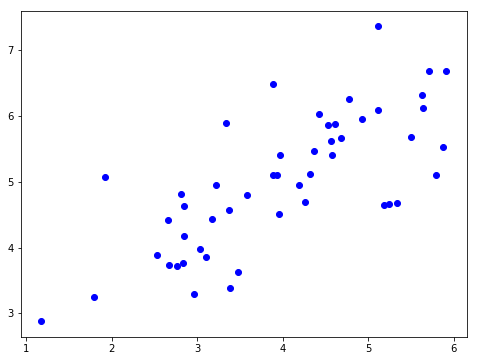

In [4]:
fig, ax = plt.subplots(figsize=(8,6))  
ax.scatter(X[:, 0], X[:, 1], c='b', marker='o') 

plt.show()

### Implementing PCA for the example dataset

PCA consists of two
computational steps: 
    
    1) First, we compute the covariance matrix of the data using the following equation:
$$ \sum = \frac{1}{m} X^TX $$

    2) Then, we use SVD function to compute the eigenvectors U1, U2, ... , Un. These will correspond to the principal components of variation in the data

Before using PCA, it is important to first normalize the data by subtracting the mean value of each feature from the dataset, and scaling each dimension so that they are in the same range.

Since numpy already has built-in functions to calculate the covariance and SVD of a matrix, we will use those rather than building from scratch.

In [5]:
# Define the pca function
def pca(X): 
    # Normalize the features
    X = (X - X.mean()) / X.std()

    # Compute the covariance matrix
    X = np.matrix(X)
    m = X.shape[0]
    covariance = (X.T * X) / m

    # Perform SVD
    U, S, V = np.linalg.svd(covariance)

    return U, S, V

In [6]:
U, S, V = pca(X)  

# Print the principal components
U, S, V 

(matrix([[-0.79241747, -0.60997914],
         [-0.60997914,  0.79241747]]),
 array([ 1.43584536,  0.56415464]),
 matrix([[-0.79241747, -0.60997914],
         [-0.60997914,  0.79241747]]))

In the above output, U will contain the principal components and S will contain a diagonal matrix.

## Dimentionality Reduction with PCA

After computing the principal components, we can use them to reduce the feature dimension of our dataset by projecting each example onto a lower dimensional space. Here, we will use the eigenvectors returned by PCA and project the example dataset into a 1-dimensional space.

**In practice, if we are using a learning algorithm such as linear regression or neural networks, we could now use the projected data instead of the original data. By using the projected data, we can train our model faster as there are less dimensions in the input.**

Lets implement a function "projectData" that computes the projection and selects only the top K components, effectively reducing the number of dimensions. Specifically, we are given a dataset X, the principal components U, and the desired number of dimensions to reduce to K. We should project each example in X onto the top K components in U. The top K components in U are given by the first K columns of U, that is U_reduced = U[:, :k].

In [7]:
def projectData(X, U, k):  
    U_reduced = U[:,:k]
    Z = np.dot(X, U_reduced)
    return Z

In [8]:
Z = projectData(X, U, 1)  

# Print the projections
Z 

matrix([[-4.74689738],
        [-7.15889408],
        [-4.79563345],
        [-4.45754509],
        [-4.80263579],
        [-7.04081342],
        [-4.97025076],
        [-8.75934561],
        [-6.2232703 ],
        [-7.04497331],
        [-6.91702866],
        [-6.79543508],
        [-6.3438312 ],
        [-6.99891495],
        [-4.54558119],
        [-8.31574426],
        [-7.16920841],
        [-5.08083842],
        [-8.54077427],
        [-6.94102769],
        [-8.5978815 ],
        [-5.76620067],
        [-8.2020797 ],
        [-6.23890078],
        [-4.37943868],
        [-5.56947441],
        [-7.53865023],
        [-7.70645413],
        [-5.17158343],
        [-6.19268884],
        [-6.24385246],
        [-8.02715303],
        [-4.81235176],
        [-7.07993347],
        [-5.45953289],
        [-7.60014707],
        [-4.39612191],
        [-7.82288033],
        [-3.40498213],
        [-6.54290343],
        [-7.17879573],
        [-5.22572421],
        [-4.83081168],
        [-7

#### Reconstructing an approximation of the data

After projecting the data onto the lower dimensional space, we can approximately recover the data by projecting them back onto the original high dimensional space. Lets project each example in Z back onto the original space and return the recovered approximation in X_rec.

In [9]:
def recoverData(Z, U, k):  
    U_reduced = U[:,:k]
    X_rec = np.dot(Z, U_reduced.T)
    return X_rec

In [10]:
X_recovered = recoverData(Z, U, 1)  
X_recovered = np.array(X_recovered)
X_recovered

array([[ 3.76152442,  2.89550838],
       [ 5.67283275,  4.36677606],
       [ 3.80014373,  2.92523637],
       [ 3.53223661,  2.71900952],
       [ 3.80569251,  2.92950765],
       [ 5.57926356,  4.29474931],
       [ 3.93851354,  3.03174929],
       [ 6.94105849,  5.3430181 ],
       [ 4.93142811,  3.79606507],
       [ 5.58255993,  4.29728676],
       [ 5.48117436,  4.21924319],
       [ 5.38482148,  4.14507365],
       [ 5.02696267,  3.8696047 ],
       [ 5.54606249,  4.26919213],
       [ 3.60199795,  2.77270971],
       [ 6.58954104,  5.07243054],
       [ 5.681006  ,  4.37306758],
       [ 4.02614513,  3.09920545],
       [ 6.76785875,  5.20969415],
       [ 5.50019161,  4.2338821 ],
       [ 6.81311151,  5.24452836],
       [ 4.56923815,  3.51726213],
       [ 6.49947125,  5.00309752],
       [ 4.94381398,  3.80559934],
       [ 3.47034372,  2.67136624],
       [ 4.41334883,  3.39726321],
       [ 5.97375815,  4.59841938],
       [ 6.10672889,  4.70077626],
       [ 4.09805306,

#### Visualizing the projections

If we then attempt to visualize the recovered data, the intuition behind how the algorithm works becomes really obvious

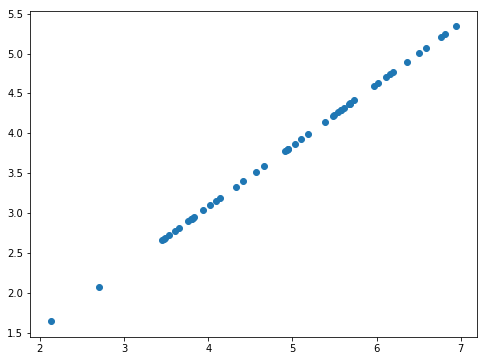

In [12]:
fig, ax = plt.subplots(figsize=(8,6))  
ax.scatter(X_recovered[:, 0], X_recovered[:, 1]) 

plt.show()

Notice how the points all seem to be compressed down to an invisible line. That invisible line is the first principal component. The second principal component, which we cut off when we reduced the data to one dimension, can be thought of as the variation orthogonal to that line. Since we lost that information, our reconstruction can only place the points relative to the first principal component.

# Dimensionality Reduction of Face Images using PCA

Now we will run PCA on face images to see how it can be used in practice for dimension reduction. The dataset "faces.mat"
contains a dataset 'X' of face images, each 32 x 32 in grayscale. Each row of X corresponds to one face image (a row vector of length 1024). Lets load and visualize a random 100 of these face images.

In [13]:
# Load the dataset
dataset = loadmat('faces.mat')  
dataset

{'X': array([[ -37.86631387,  -45.86631387,  -53.86631387, ..., -110.86631387,
         -111.86631387,  -99.86631387],
        [   8.13368613,   -0.86631387,   -8.86631387, ...,  -34.86631387,
           -8.86631387,    0.13368613],
        [ -32.86631387,  -34.86631387,  -36.86631387, ..., -110.86631387,
         -111.86631387, -111.86631387],
        ..., 
        [ -46.86631387,  -24.86631387,   -8.86631387, ...,   90.13368613,
           80.13368613,   59.13368613],
        [  19.13368613,   16.13368613,   14.13368613, ...,  -38.86631387,
          -41.86631387,  -46.86631387],
        [-108.86631387, -106.86631387, -102.86631387, ...,   17.13368613,
           17.13368613,   18.13368613]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Nov 14 23:46:35 2011',
 '__version__': '1.0'}

In [14]:
X = dataset['X']

# Print the shape of 'X'
X.shape

(5000, 1024)

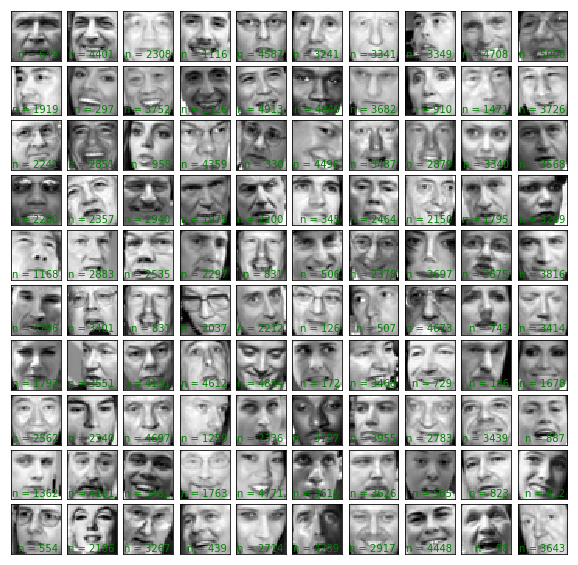

In [15]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    rand_n = np.random.randint(5000)
    im = X[rand_n, :]

    ax.imshow(im.reshape((32, 32), order='F'), cmap='gray')
    ax.text(0.95, 0.05, 'n = {0}'.format(rand_n + 1), ha='right',
            transform=ax.transAxes, color='green')
    ax.set_xticks([])
    ax.set_yticks([])

### Implementing PCA on faces

To run PCA on the face dataset, we follow the same steps that were followed for the example dataset. After running PCA, we will
obtain the principal components of the dataset. Notice that each principal component in U (each row) is a vector of length 'n' (where for the face dataset, n = 1024). We can visualize these principal components by reshaping each of them into a 32 x 32 matrix that corresponds to the pixels in the original dataset.

In [16]:
U, S, V = pca(X)  
Z = projectData(X, U, 100) 
Z

matrix([[  526.09608833,   734.37008142,   194.48322788, ...,
           -19.27422565,    -3.22314155,    20.93551538],
        [  304.5906028 ,   493.0633805 ,  -162.10424193, ...,
           -20.94839919,    17.86358442,    -8.14045979],
        [ -389.99893833,   600.20010851,  -293.91694459, ...,
           -27.86998851,    48.74829475,    17.98452065],
        ..., 
        [  487.55926046,   430.86037345,   490.71749378, ...,
           -31.76395627,    23.77770829,    51.74592358],
        [ 1358.99575656,   402.85437502,  -136.10305216, ...,
           -10.45305753,    -2.76084233,     2.96467067],
        [  372.01599145,   360.59923883,   105.10564415, ...,
           -48.29644614,    -8.75071522,   -30.24094867]])

This process of dimension reduction allows us to use our learning algorithms with a smaller input size (e.g., 100 dimensions) instead of the original 1024 dimensions which can help speed up our learning algorithm.

#### Recover the original structure

To understand what is lost in the dimension reduction, we can recover the data using only the projected dataset. 

In [17]:
X_recovered = recoverData(Z, U, 100)  

Lets display the projected face images. From the reconstruction, we can observe that the general structure and appearance of the face are in-tact while the fine details are lost. This is a remarkable reduction (more than 10x) in the dataset size that can help speed up our learning algorithm significantly. For example, if we were training a neural network to perform person recognition (given a face image, predict the identity of the person), we can use the dimension reduced input of only a 100 dimensions instead of the original pixels.

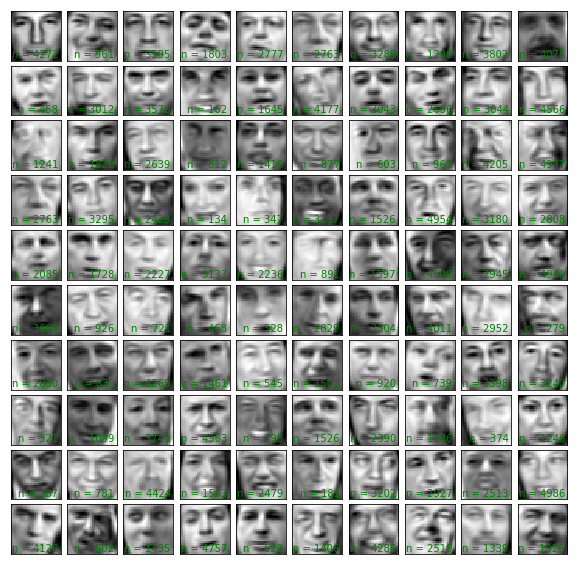

In [18]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    rand_n = np.random.randint(5000)
    im = X_recovered[rand_n, :]

    ax.imshow(im.reshape((32, 32), order='F'), cmap='gray')
    ax.text(0.95, 0.05, 'n = {0}'.format(rand_n + 1), ha='right',
            transform=ax.transAxes, color='green')
    ax.set_xticks([])
    ax.set_yticks([])